<a href="https://colab.research.google.com/github/nkharlamova/ML/blob/main/HW8_class_disbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TASK: Classification, disbalance handling, and checking the impact on model accuracy.**

**Dataset https://archive.ics.uci.edu/ml/datasets/glass+identification**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

import seaborn as sns
import matplotlib.pyplot as plt

**Loading the dataset**

In [ ]:
# Завантажимо наш датасет
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"
column_names = ["Id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Class"]
df = pd.read_csv(url, names=column_names, index_col="Id")
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Class
Id,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


**Checking for missing values and the data types of the columns**

In [ ]:
# Перевіряємо чи є пропущені значення і які типи мають колонки
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 1 to 214
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Class   214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 18.4 KB


**There are no missing values and all columns are numerical.**

In [ ]:
# Пропущених значень немає, і всі колонки числові

**Let's take a look at the description.**

In [ ]:
# Подивимось опис
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Class
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


**We have a total of 7 classes, so let's create a chart and look at their distribution.**

In [ ]:
# Маємо всього 7 класів, тож побудуємо графік і подивимося на їх розподіл

<Axes: xlabel='Class', ylabel='count'>

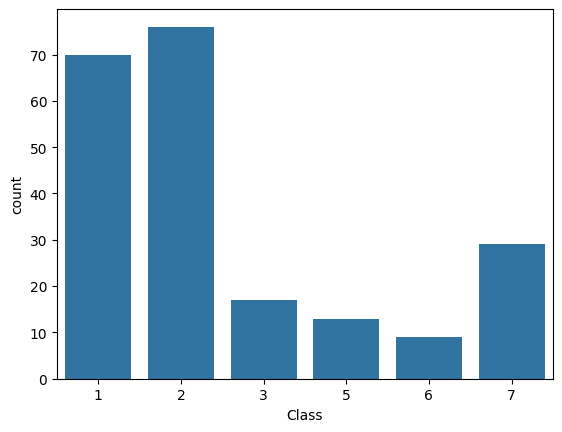

In [ ]:
sns.countplot(data=df, x="Class")

**We can see that the distribution is far from normal, which means the data in this dataset is highly disbalanced.**

In [ ]:
# Бачимо, що розподіл далекий від нормального, а значить в цьому датасеті дані дуже незбалансовані

**Let's take a look at the numerical values.**

In [ ]:
# Подивимось додатково числові значення
df.Class.value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Class, dtype: int64

**The same situation.**

In [ ]:
# та ж картина

**Let's take a look at the correlation matrix.**

<Axes: >

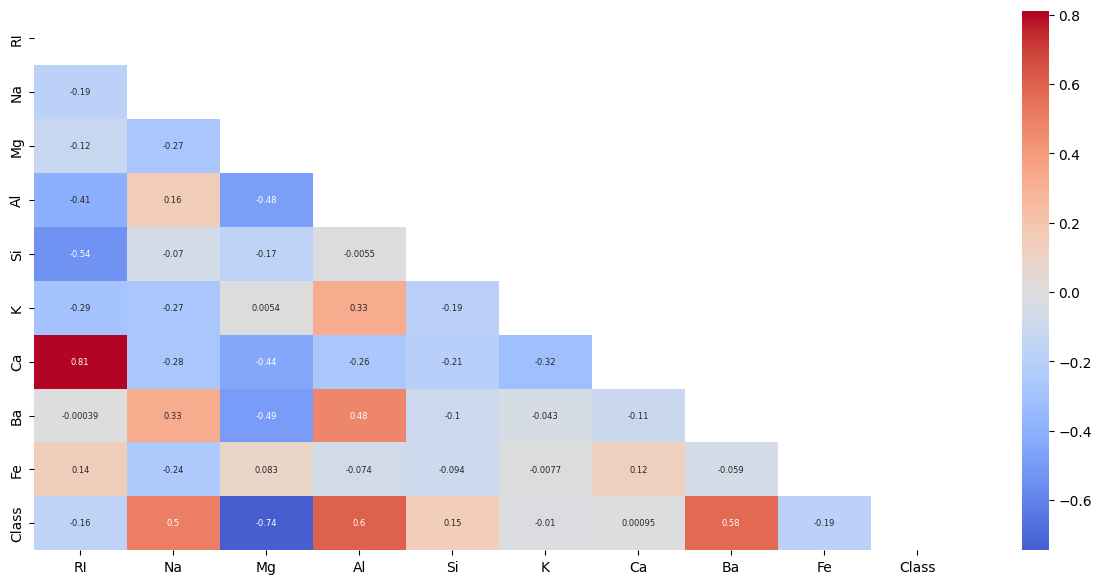

In [ ]:
# Розглянемо матрицю кореляцій
corr_df = df.corr()
plt.figure(figsize=(15, 7))
matrix = np.triu(corr_df.corr())
sns.heatmap(corr_df, cmap="coolwarm", annot=True, annot_kws={"fontsize":6}, center= 0, mask=matrix)

**We can observe only one strong relationship between the indicators of Ca and RI.**

In [ ]:
# Бачимо тілько один сильний зв'язок між показниками Ca та RI.

**Let's add new features.**

**The 1st feature - the sum of the content of all metals**

In [ ]:
# Додамо декілька нових фіч
# 1. Рахуємо суму вмісту всіх металів
df.insert(2, "total_met", df[["Mg", "Al", "K", "Ca", "Ba", "Fe"]].sum(axis=1))

**The 2nd feature - the sum of the alkali metals content**

In [ ]:
# 2. Рахуємо суму вмісту лужних металів
df.insert(2, "total_alkali_met", df[["Na", "K"]].sum(axis=1))


**The 3rd feature - the ratio of calcium content to sodium content**

In [ ]:
# 3. Рахуємо відношення вмісту кальцію до вмісту натрія
df.insert(2, "Ca_Na_ratio", df["Ca"] / df["Na"])

**Let's take a look at the new correlation matrix.**

<Axes: >

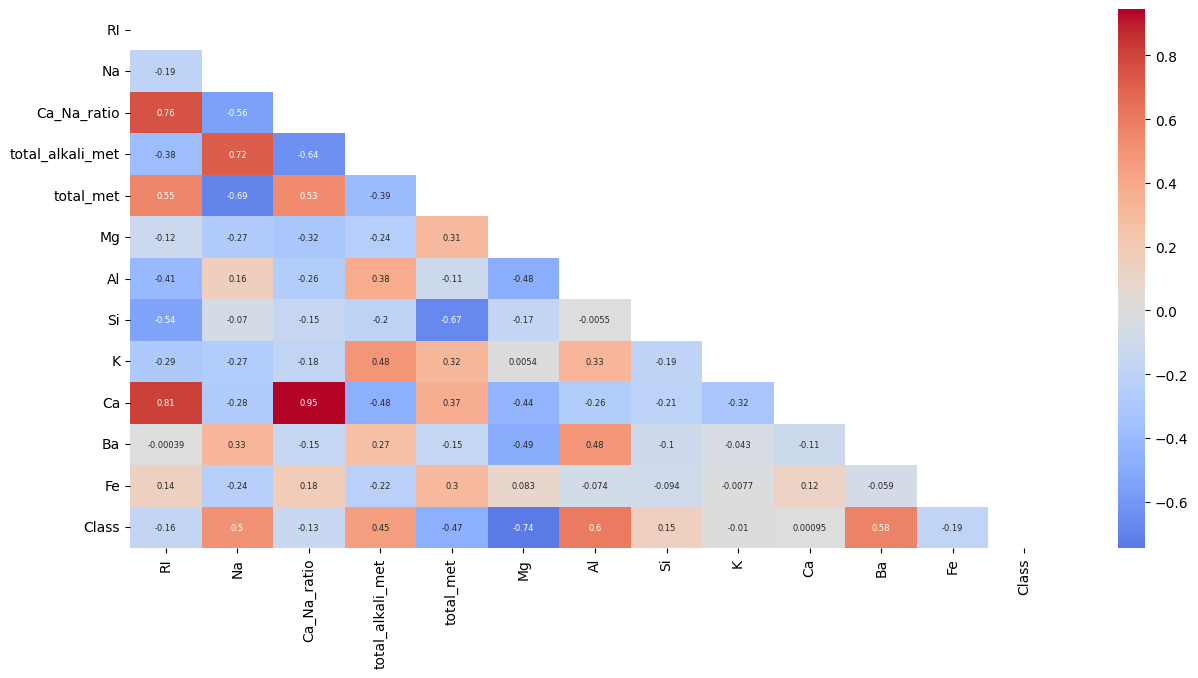

In [ ]:
# Подивимось нову матрицю кореляцій
corr_df = df.corr()
plt.figure(figsize=(15, 7))
matrix = np.triu(corr_df.corr())
sns.heatmap(corr_df, cmap="coolwarm", annot=True, annot_kws={"fontsize":6}, center= 0, mask=matrix)

**We observe a high correlation of 0.95 between calcium and our new feature, the ratio of calcium to sodium content, so we'll remove this correlation using factorization methods.**

In [ ]:
# Бачимо високу кореляцію 0.95 між кальцієм та нашою новою фічею відношення вмісту елементів Ca/Na
# Видаляємо цю кореляцію з використанням методу факторизації
pca = PCA(n_components=1)
df[["CaNa_rat_PCA"]] = pca.fit_transform(df[["Ca", "Ca_Na_ratio"]])
df = df.drop(["Ca", "Ca_Na_ratio"], axis=1)

**Let's take a look at the updated correlation matrix**

<Axes: >

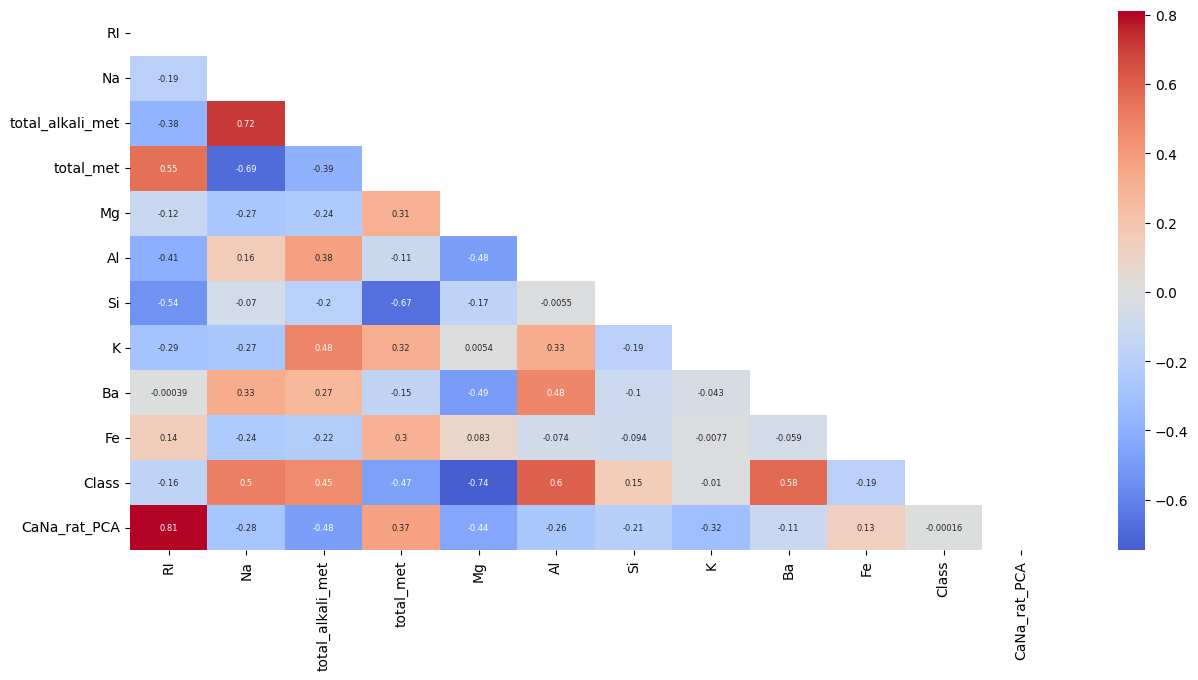

In [ ]:
# Дивимося що вийшло
corr_df = df.corr()
plt.figure(figsize=(15, 7))
matrix = np.triu(corr_df.corr())
sns.heatmap(corr_df, cmap="coolwarm", annot=True, annot_kws={"fontsize":6}, center= 0, mask=matrix)

**Everything is fine**

In [ ]:
# Все добре, йдемо далі

**Let's display separately the sorted correlation between the independent variable (Class) and the dependent variables**

In [ ]:
# Відобразимо окремо відсортовану кореляцію між незалежною (Class) та залежними змінними
corr_with_class = df.corr().Class.sort_values(ascending=False, key = lambda x: abs(x)).to_frame()
corr_with_class.drop("Class")

,Class
Mg,-0.744993
Al,0.598829
Ba,0.575161
Na,0.502898
total_met,-0.473682
total_alkali_met,0.449353
Fe,-0.188278
RI,-0.164237
Si,0.151565
K,-0.010054


**There's nothing critical in terms of correlation with the target, but there is some influence observed from the indicators Mg, Al, Ba, and Na.**

In [ ]:
# По кореляції з таргетом нічого критичного немає,
# але відслідковується деякий вплив показників Mg, Al, Ba та Na.

**Let's build a pairplot to see the correlations between variables**

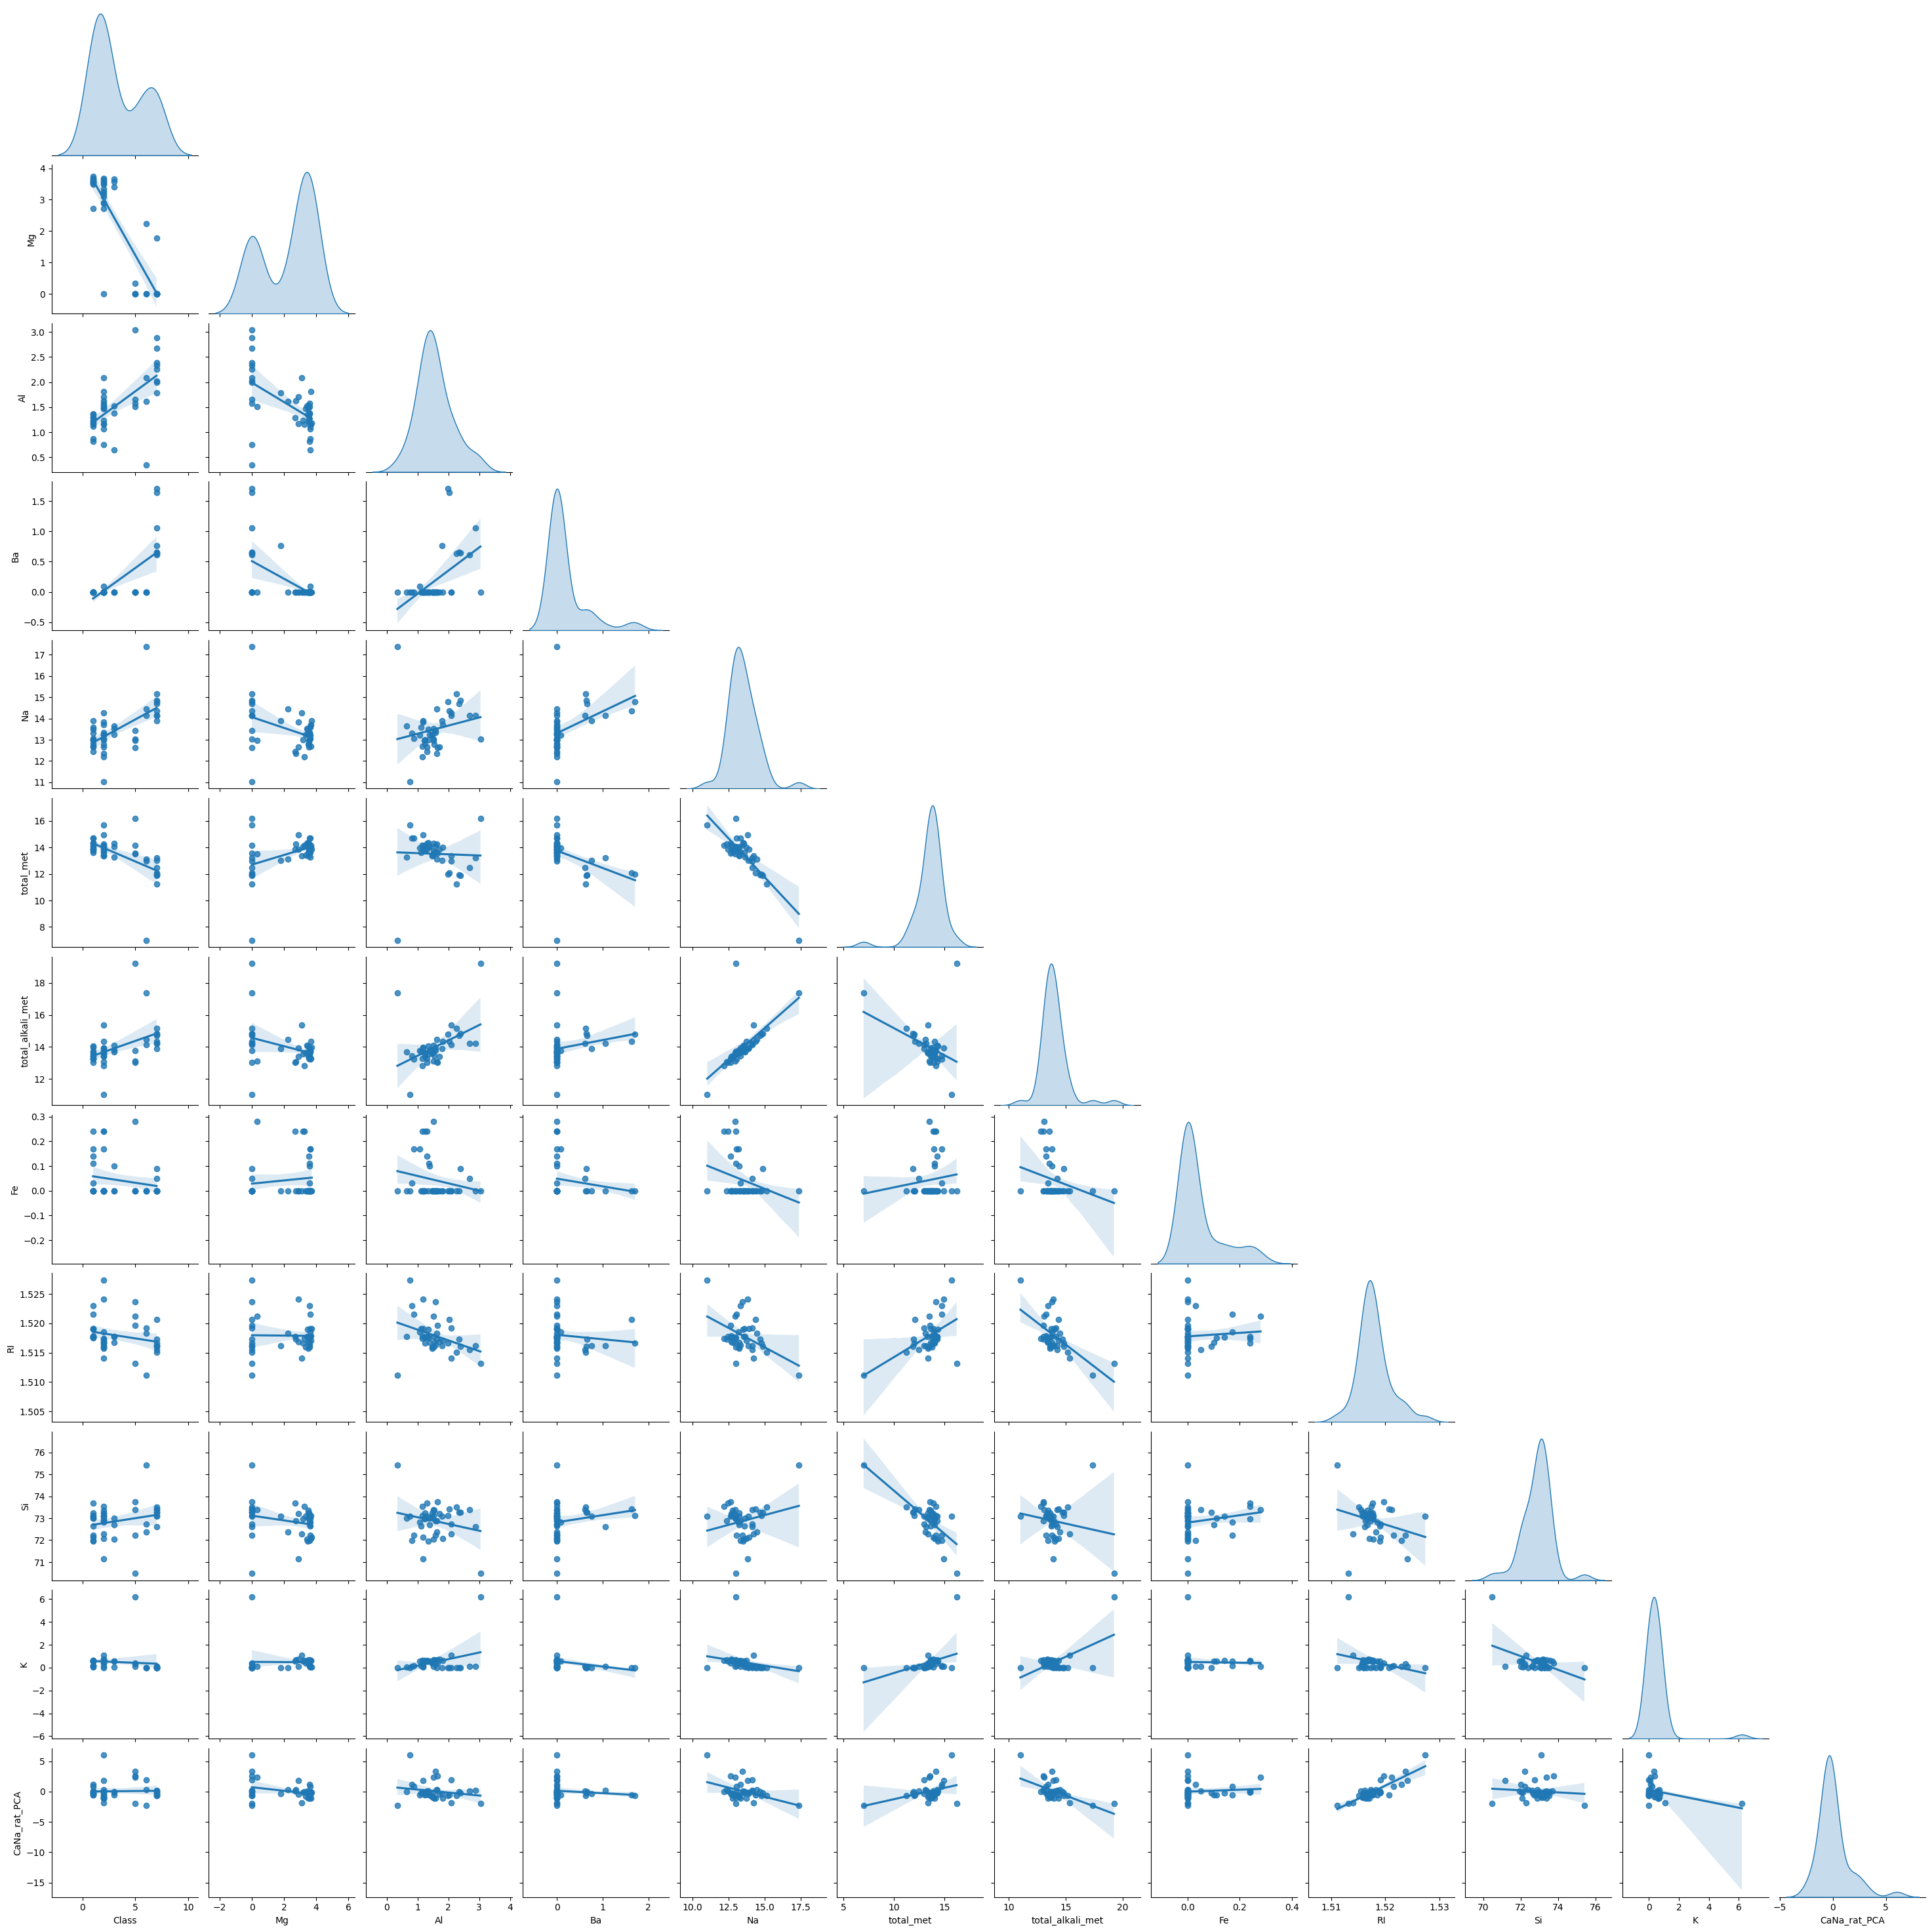

In [ ]:
# Побудуємо pairplot, щоб побачити взаємозв'язки між змінними
features = corr_with_class[abs(corr_with_class.Class) > 0].index.tolist()
sns.pairplot(df[features].sample(frac=0.2, random_state=42), corner=True, kind="reg", diag_kind="kde")

**As the previous correlation matrix showed, the correlation between variables are mostly distant**

In [ ]:
# як і показала попередня матриця кореляцій, зв'язки між змінними в більшості віддалені

**Splitting the dataset into a feature matrix**

In [ ]:
# Розділяємо датасет на матрицю фіч
X = df.drop("Class", axis=1)
y = df["Class"]

**Scaling the features**

In [ ]:
# Масштабуємо фічі
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Splitting the dataset into training and test parts**

In [ ]:
# Розділяємо датасет на тренувальну та тестову частини
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

**Applying the oversampling method (SMOTE) to eliminate the disbalance**

In [ ]:
# Застосуємо метод oversampling (SMOTE) для усунення дисбалансу
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

**Creating and training a RandomForest model**

In [ ]:
# creating a RandomForest model
# Створюємо модель RandomForest і навчаємо її
model = RandomForestClassifier(random_state=42)

# cross-validation:
# Робимо крос-валідацію:
cv_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5)

# training the model:
# Тренуємо модель
model.fit(X_train_resampled, y_train_resampled)

# calculating the evaluation on the training and test samples:
# Розраховуємо оцінку на тренувальній та тестовій вибірці:
train_score = model.score(X_train_resampled, y_train_resampled)
test_score = model.score(X_test, y_test)

# print the evaluations:
# Дивимося оцінку по фолдам а також по тренувальній та тестовій виборкам:
print("Cross-Validation Scores:", cv_scores)
print("Train Score:", train_score)
print("Test Score:", test_score)


Cross-Validation Scores: [0.81333333 0.85333333 0.97297297 0.90540541 0.91891892]
Train Score: 1.0
Test Score: 0.813953488372093


**We have fairly good metrics; we could say the model generalizes the data well. However, according to the Test Score evaluation, there is a suggestion that the model may not predict as accurately on test data as it does on training data. Such a difference between Train Score and Test Score may indicate overfitting, so it makes sense to look at the standard deviation of the scores from cross-validation.**

In [ ]:
# Маємо досить непогані показники, можна сказати, що модель добре узагальнює дані,
# але згідно з оцінкою Test Score можна припустити, що модель може не так точно прогнозувати на тестових даних, як на тренувальних.
# Така різниця між Train Score та Test Score може свідчити про те, що модель перетренована,
# тож є сенс подивитися ще на стандартне відхилення оцінок по нашій кросс-валідації

In [ ]:
std_deviation = np.std(cv_scores)
print(f"Standard deviation of cv-scores: {std_deviation}")

Standard deviation of cv-scores: 0.05502975267148209


**The standard deviation is relatively low, so we can conclude that the cross-validation scores are more or less stable and there is no overfitting.**

In [ ]:
# Стандартне відхилення є відносно низьким, тож можна зробити висновок, що оцінки по крос-валідації більш-менш стабільні і перетренування немає

**Model accuracy, model quality, and class disbalance assessment:**

In [ ]:
# Подивимося оцінки
y_pred = model.predict(X_test)

# evaluating the accuracy of the model:
# Робимо оцінку точності моделі
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# evaluating the class disbalance:
# Робимо оцінку дисбалансу класів
class_counts = y_train_resampled.value_counts()
print("Balanced class counts after SMOTE:")
print(class_counts)

# evaluating the quality of the model:
# Робимо оцінку якості моделі
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.81
Balanced class counts after SMOTE:
2    62
3    62
1    62
7    62
5    62
6    62
Name: Class, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           1       0.73      0.73      0.73        11
           2       1.00      0.71      0.83        14
           3       0.33      0.67      0.44         3
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         3
           7       0.89      1.00      0.94         8

    accuracy                           0.81        43
   macro avg       0.82      0.85      0.82        43
weighted avg       0.86      0.81      0.83        43



**CONCLUSION: According to the Classification Report, Class 3 has the worst metrics. This may indicate that most of the objects predicted by the model as Class 3 are not actually Class 3. For other classes, the model performed quite successfully. The macro avg and weighted avg metrics are also quite high, indicating overall model performance.**

In [ ]:
# Згідно звіту Classification Report, по класу 3 маємо найгірші показники.
# Це може означати, що більшість об'єктів, що були спрогнозовані моделлю як 3й клас, фактично ним не є.
# По іншим класам модель спрацювала досить успішно.
# Показники macro avg і weighted avg також досить високі, що свідчить про загальну продуктивність моделі.